# 🔵 **Dependencies**




In [1]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 5.2 MB/s eta 0:00:00


In [2]:
#for windows
!pip install -q soundfile
#for linux
!pip install -q sox

In [3]:
!pip install -q librosa

# 🔵 **Imports**

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn.functional as F

import torchaudio
from torchaudio import datasets
from torchaudio import transforms as T
from torchaudio import models
from torchaudio import pipelines

from torch.nn.utils.rnn import pad_sequence

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


import numpy  as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torchmetrics as tm
from tqdm import tqdm
import librosa
from collections import Counter

from IPython.display import Audio

In [5]:
!python --version

Python 3.10.12


In [6]:
for lib in [np, torch, torchaudio, torchtext, pd, tm, librosa]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
torch --> 2.1.0+cu118
torchaudio --> 2.1.0+cu118
torchtext --> 0.16.0+cpu
pandas --> 1.5.3
torchmetrics --> 1.2.1
librosa --> 0.10.1


# 🔵 **Utils**

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [8]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [9]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

In [10]:
def print_stats(waveform, sample_rate = None, src = None):
  if src:
    print("_" * 10)
    print("Source:", src)
    print("_" * 10)

  if sample_rate:
    print("Sample Rate: ", sample_rate)

  print('Shape: ', tuple(waveform.shape))
  print('DType: ', waveform.dtype)
  print(f" - Max:   {waveform.max().item():6.3f}")
  print(f" - Min:   {waveform.min().item():6.3f}")
  print(f" - Mean:   {waveform.mean().item():6.3f}")
  print(f" - Std Dev:   {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

In [11]:
def plot_waveform(waveform, sample_rate, title = 'Waveform', xlim = None, ylim = None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth = 1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channels {c + 1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)

    figure.suptitle(title)
    plt.show(block = False)

In [12]:
def plot_spectrogram(specgram, title = None, ylabel = 'freq_bin'):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(T.AmplitudeToDB()(specgram), origin = 'lower')
  fig.colorbar(im, ax = axs)
  plt.show(block = False)

# 🔵 **Dataset**

## 🔵 **LoadDataset**

In [13]:
dataset = datasets.LJSPEECH('/content/', 'https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2', download = True)

100%|██████████| 2.56G/2.56G [01:16<00:00, 36.2MB/s]


In [14]:
len(dataset)

13100

In [15]:
import csv
with open('/content/LJSpeech-1.1/metadata.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    file = []
    for row in spamreader:
        file.append(' '.join(row))

In [16]:
csv_dataset = []
for sen in file:
  sent = sen.split('|')
  csv_dataset.append([sent[0], sent[1]])

In [17]:
data_df = pd.DataFrame(csv_dataset, columns = ['id', 'text'])
data_df

,id,text
0,LJ001-0001,"Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...
...,...,...
13095,LJ050-0274,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...


In [18]:
class SplitData():
  def __init__(self, data_path):
    super(SplitData, self).__init__()
    data = np.loadtxt(data_path, dtype = str).tolist()
    self.ids = []
    for name in data:
      id = data_df[data_df['id'] == name].index.item()
      self.ids.append(id)

  def __call__(self, idx):
    return dataset[self.ids[idx]]

  def __len__(self):
    return len(self.ids)

In [22]:
train_set = SplitData('train.txt')
valid_set = SplitData('valid.txt')
test_set  = SplitData('test.txt')

In [23]:
len(train_set), len(valid_set), len(test_set)

(12500, 100, 500)

In [24]:
tokenizer = get_tokenizer('basic_english')

In [25]:
sentences = []
for i in range(len(train_set)):
  sentences.append(train_set(i)[2])

In [26]:
train_tokens = tokenizer(' '.join(sentences))
len(train_tokens)

238961

In [27]:
train_tokens[0:20]

['it',
 'has',
 'used',
 'other',
 'treasury',
 'law',
 'enforcement',
 'agents',
 'on',
 'special',
 'experiments',
 'in',
 'building',
 'and',
 'route',
 'surveys',
 'in',
 'places',
 'to',
 'which']

In [28]:
vocab  = build_vocab_from_iterator([train_tokens], min_freq = 0, specials = ['<unk>', '<pad>' ,'<sos>', '<eos>'])
vocab.set_default_index(vocab['<unk>'])
len(vocab.get_itos())

14420

## 🔵 **EDA**

In [29]:
l_sentences = []
for sentence in sentences:
  l_sentences.append(len(tokenizer(sentence)))

In [30]:
L_df = pd.DataFrame(l_sentences, index = sentences, columns = ['L'])
L_df

,L
It has used other Treasury law enforcement agents on special experiments in building and route surveys in places to which the President frequently travels.,25
"to avail himself of his powers, as it was difficult to bring home the derelictions of duties and evasion of the acts. Too much was left to the inspectors.",32
"Although Chief Rowley does not complain about the pay scale for Secret Service agents,",15
"The three officers confirm that their primary concern was crowd and traffic control,",14
"The tried and the untried, young and old, were herded together",13
...,...
In another part seven persons met their death by suffocation.,11
"However, the 1964 to 65 budget request was submitted in November 1963",13
It is the American people themselves who expect the third horse to pull in unison with the other two.,20
"Handwriting experts, Alwyn Cole of the Treasury Department and James C. Cadigan of the FBI,",18


In [31]:
L_df.describe()

,L
count,12500.000000
mean,19.116880
std,6.699236
min,1.000000
25%,14.000000
50%,19.000000
75%,24.000000
max,44.000000


In [32]:
word_counts = Counter()
for word in train_tokens:
    word_counts.update([word])

In [33]:
N_word = pd.DataFrame(word_counts.values(), index = word_counts.keys(), columns = ['N']).sort_values('N')
N_word.describe()

,N
count,14416.000000
mean,16.576096
std,246.406432
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,17474.000000


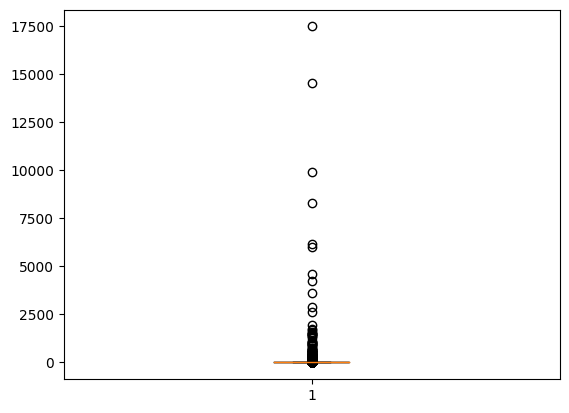

In [34]:
plt.boxplot(N_word)
plt.show()

In [35]:
N_word[N_word['N']>5000]

,N
to,6028
and,6165
of,8319
.,9905
",",14518
the,17474


In [36]:
N_word[N_word['N']<2]

,N
alwyn,1
provocation,1
dissolution,1
smug,1
happening,1
...,...
better-regulated,1
oversee,1
nominated,1
bravo,1


In [37]:
waveform, sample_rate, text, _  = train_set(0)

Sample Rate:  22050
Shape:  (1, 217501)
DType:  torch.float32
 - Max:    0.474
 - Min:   -0.413
 - Mean:   -0.000
 - Std Dev:    0.061

tensor([[0.0003, 0.0004, 0.0003,  ..., 0.0013, 0.0012, 0.0002]])



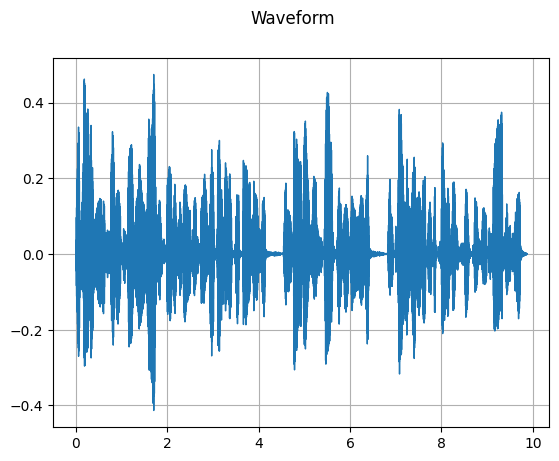

In [38]:
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)
mel_spectro = T.MelSpectrogram(sample_rate, n_fft = 1024, hop_length = 128, n_mels = 150)
spec = mel_spectro(waveform)

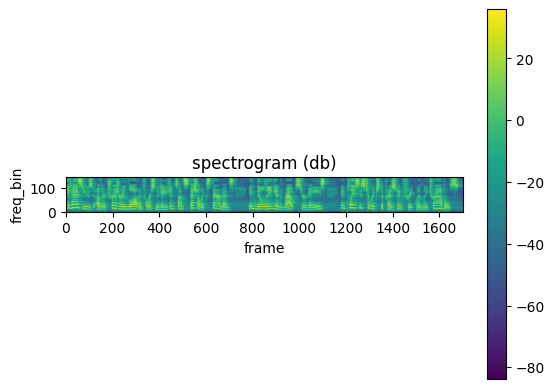

In [39]:
plot_spectrogram(spec[0])

In [40]:
text

'It has used other Treasury law enforcement agents on special experiments in building and route surveys in places to which the President frequently travels.'

In [41]:
Audio(waveform.numpy(), rate = sample_rate)

In [42]:
wav_info = []
for i in range(len(train_set)):
  sample, sample_rate, _, _  = train_set(i)
  wav_info.append([sample.shape[1]/sample_rate, sample.mean().item(), sample.std().item()])

In [43]:
wav_df = pd.DataFrame(wav_info, columns = ['time', 'mean', 'std'])
wav_df.describe()

,time,mean,std
count,12500.000000,12500.000000,12500.000000
mean,6.576561,0.000009,0.066083
std,2.182036,0.000008,0.009615
min,1.110068,-0.000074,0.032051
25%,4.987800,0.000004,0.059395
50%,6.764127,0.000008,0.065272
75%,8.389524,0.000013,0.071681
max,10.096190,0.000068,0.130990


### average mean = 0.000009 ||| average std = 0.066083

## 🔵 **CustomDataset**

In [44]:
class LJSpeechDataset(Dataset):
  def __init__(self, dataset, tokenizer, vocab, transform = None):
    super(LJSpeechDataset, self).__init__()
    self.dataset   = dataset
    self.tokenizer = tokenizer
    self.vocab     = vocab
    self.transform = transform

  def __getitem__(self, idx):
    wavform, sample_rate, text, _ = self.dataset(idx)

    if self.transform:
      input = self.transform(wavform)
    else:
      input = T.Spectrogram(n_fft = 1024, hop_length = 128)(wavform)

    text_idx = [self.vocab[token] for token in self.tokenizer('<sos> ' + text + ' <eos>')]
    target   = torch.LongTensor(text_idx)

    return input, target

  def __len__(self):
    return len(self.dataset)

In [45]:
train_dataset = LJSpeechDataset(train_set, tokenizer, vocab, None)
valid_dataset = LJSpeechDataset(valid_set, tokenizer, vocab, None)
test_dataset  = LJSpeechDataset(test_set, tokenizer, vocab, None)

In [46]:
spec, taregt = train_dataset[0]
spec.shape, taregt

(torch.Size([1, 513, 1700]),
 tensor([    2,    21,    75,   202,    54,   875,   222,   620,   161,    16,
           288, 10516,    10,   144,     8,   322,  4927,    10,  1004,     9,
            26,     4,    43,   672,  4202,     6,     3]))

In [47]:
Audio(T.InverseSpectrogram(n_fft = 1024, hop_length = 128)(spec.type(torch.complex64)), rate = 22050)

In [48]:
dataset[0][0].shape

torch.Size([1, 212893])

In [49]:
train_set(0)[0].shape

torch.Size([1, 217501])

## 🔵 **Visualize**

In [56]:
import random
def visualize_random_sample(n, dataset, vocab):

  n_random_idx = random.sample(range(0, len(dataset) - 1), n)

  audios = []
  texts  = []
  for idx in n_random_idx:

      spec, text_idx = dataset[idx]

      wavform = T.InverseSpectrogram(n_fft = 1024, hop_length = 128)(spec.type(torch.complex64))
      audios.append(Audio(wavform, rate = 22050))
      display(plot_spectrogram(spec[0]))
      display(Audio(wavform, rate = 22050))


      text = [vocab.get_itos()[index] for index in text_idx.tolist()]
      texts.append(text)
      print(' '.join(text))

  return audios, texts

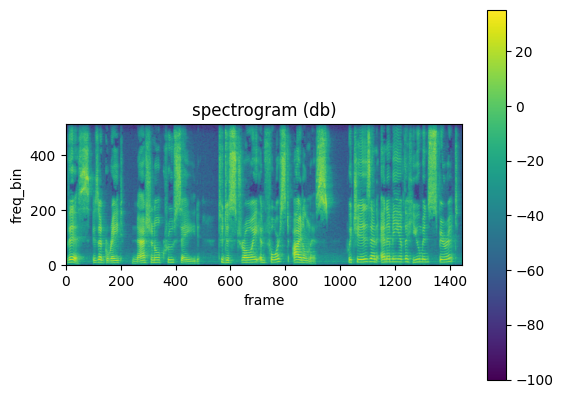

None

<sos> this is a great national crusade to destroy enforced idleness which is an enemy of the human spirit <eos>


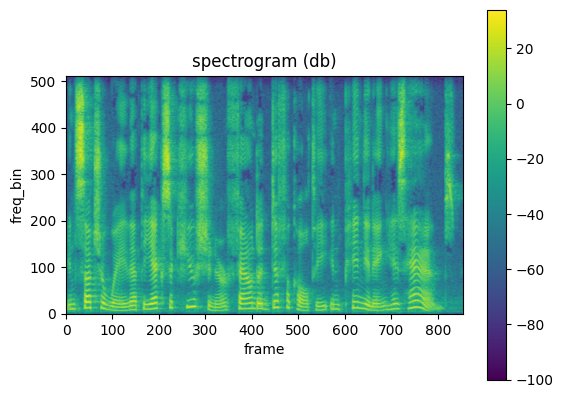

None

<sos> in such a way that the executioner found a difficulty in pinioning his hands . <eos>


In [58]:
audios, texts = visualize_random_sample(2, train_dataset, vocab)

## 🔵 **DataLoader**

In [62]:
def collate_fn(batch):
  samples = [b[0][0].t() for b in batch]
  samples = pad_sequence(samples, batch_first = True)
  targets  = [b[1] for b in batch]
  targets  = pad_sequence(targets, batch_first = True, padding_value = vocab['<pad>'])
  return samples, targets

In [63]:
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, collate_fn = collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = False, collate_fn = collate_fn)
test_loader  = DataLoader(test_dataset , batch_size = 32, shuffle = False, collate_fn = collate_fn)

In [64]:
input, target = next(iter(train_loader))

In [65]:
input.shape, target.shape

(torch.Size([16, 1696, 513]), torch.Size([16, 36]))